In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt

import h5py
from tqdm import tqdm

import torch
import torch.utils.data
from torch import nn, optim

from utils.data import test_loader

/data1/jcampos/.conda/envs/ml4qick-env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data1/jcampos/.conda/envs/ml4qick-env/lib/python3.7/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
csr = range(500,1500) 
sr = len(csr) 

# Must rewrite initialization for hls4ml. Models are read based on PyTorch serialization implementation 
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.linear1_activations = torch.tensor([])
        self.linear2_activations = torch.tensor([])
        self.bn_activations = torch.tensor([])
        self.relu1_activations = torch.tensor([])
        self.relu2_activations = torch.tensor([])

        self.hn = sr*2 * 1

        self.linear1 = nn.Linear(sr*2, int(self.hn/8))
        self.relu1 = nn.ReLU()
        self.bn = nn.BatchNorm1d(int(self.hn/8), affine=True)

        self.linear2 = nn.Linear(int(self.hn/8), 2)
        self.relu2 = nn.ReLU()

    def forward(self, sig):
        x = self.linear1(sig)
        self.linear1_activations = torch.cat((self.linear1_activations, x.float()), 0)

        x = self.relu1(x)
        self.relu1_activations = torch.cat((self.relu1_activations, x.float()), 0)
        x = self.bn(x)
        self.bn_activations = torch.cat((self.bn_activations, x.float()), 0)

        x = self.linear2(x)
        self.linear2_activations = torch.cat((self.linear2_activations, x.float()), 0)
        x = self.relu2(x)
        self.relu2_activations = torch.cat((self.relu2_activations, x.float()), 0)
        return x

In [3]:
model = Classifier() 
model.load_state_dict(torch.load("../checkpoints/checkpoint_tiny_affine.pth")) 

<All keys matched successfully>

In [4]:
# Readout Fidelity
device = 'cpu'
model.eval() 
cc = 0
y_true = torch.tensor([]).to(device)
y_pred = torch.tensor([]).to(device)

with torch.no_grad():
    for data, target in test_loader:
        
        data=data.to(device)
        states = model(data)
        target = target.to(device) 

        val, ind = torch.max(states,1)
        y_pred = torch.cat((y_pred, ind.float()), 0)
        y_true = torch.cat((y_true, target), 0)

acc = y_true-y_pred
# accuracy = (len(y_true)-torch.count_nonzero(acc))/len(y_true)
accuracy = (len(y_true)-(acc==-1).sum().float())/len(y_true)
accuracy = accuracy.item()

print('Readout Fidelity: %', accuracy*100)

num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Model Parameters: %', num_parameters)


Readout Fidelity: % 95.3000009059906
Model Parameters: % 501252


### Distribution Weight/Bias

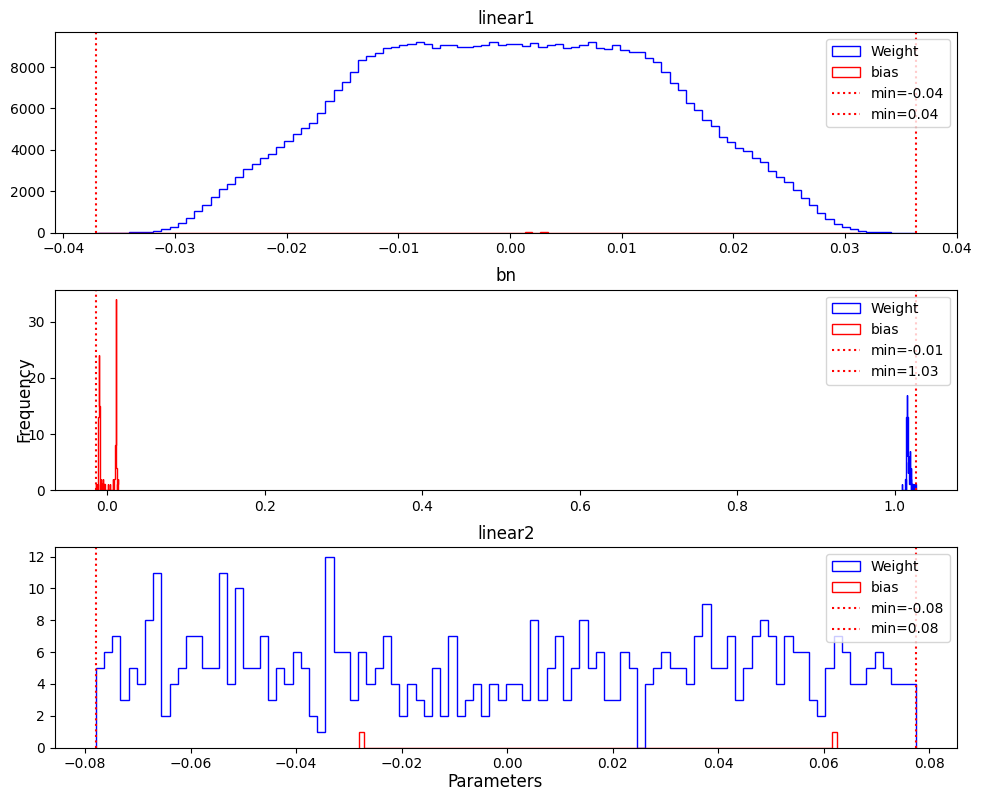

In [5]:
layers = ['linear1', 'bn', 'linear2']

fig, axs = plt.subplots(int(len(layers)), 1, figsize=(10, 8))
fig.tight_layout(pad=2.0)

for idx, layer_name in enumerate(layers):
    try:
        layer = getattr(model, layer_name)
    except Exception as e:
        print(f'Failed retrieving layer {layer}')
        print(e)

    # if isinstance(layer, nn.Linear):
    #     weight_data = layer.weight.data.reshape(-1)
    #     bias_data = layer.bias.data.reshape(-1)
    #     axs[idx].hist(weight_data, bins=100, histtype='step', color='blue')
    #     axs[idx].hist(bias_data, bins=100, histtype='step', color='red')
    # elif isinstance(layer, nn.BatchNorm1d):
    weight_data = layer.weight.data.reshape(-1)
    bias_data = layer.bias.data.reshape(-1)
    axs[idx].hist(layer.weight.data.reshape(-1), bins=100, histtype='step', color='blue', label='Weight')
    axs[idx].hist(layer.bias.data.reshape(-1), bins=100, histtype='step', color='red', label='bias')

    data_min = min(weight_data.min(), bias_data.min())
    data_max = max(weight_data.max(), bias_data.max())
    axs[idx].axvline(x=data_min, color='red', ls=':', label=f'min={data_min:.2f}')
    axs[idx].axvline(x=data_max, color='red', ls=':', label=f'min={data_max:.2f}')
    
    axs[idx].title.set_text(layer_name)
    axs[idx].legend(loc='upper right')

fig.supxlabel('Parameters')
fig.supylabel('Frequency')
plt.show()

### Distribution of activations

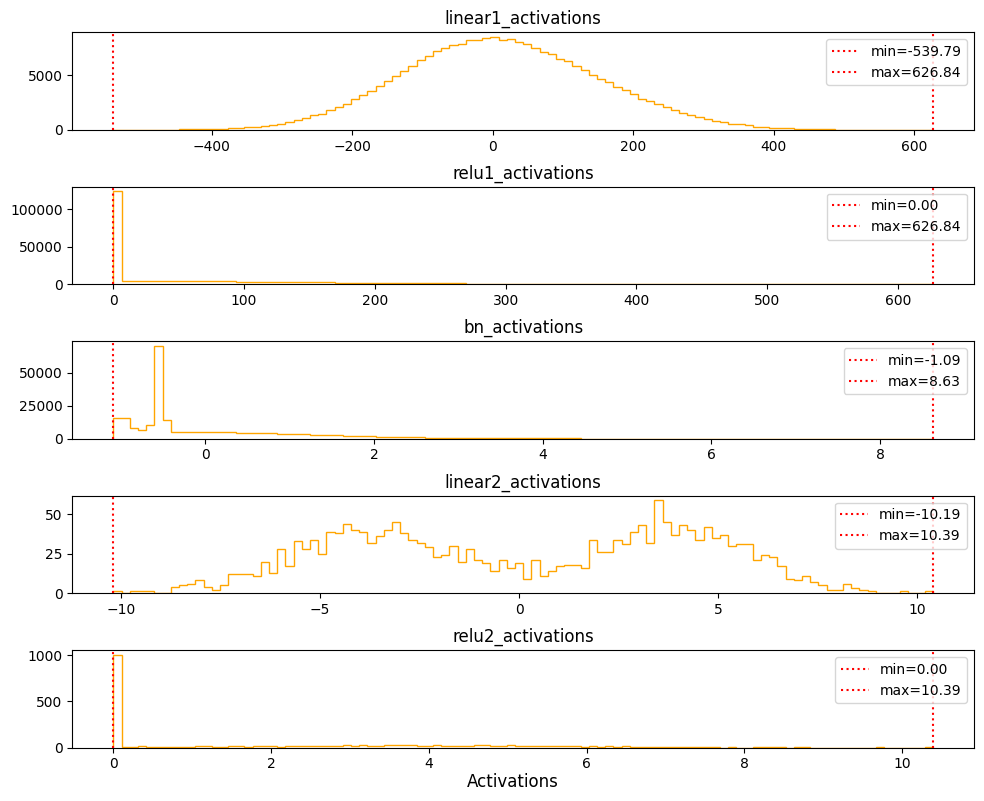

In [6]:
layers = ['linear1_activations', 'relu1_activations', 'bn_activations', 'linear2_activations', 'relu2_activations']

fig, axs = plt.subplots(int(len(layers)), 1, figsize=(10, 8))
fig.tight_layout(pad=2.0)

for idx, layer_name in enumerate(layers):
    try:
        layer = getattr(model, layer_name)
    except Exception as e:
        print(f'Failed retrieving {layer}')
        print(e)

    data = layer.reshape(-1)
    axs[idx].hist(data, bins=100, histtype='step', color='orange')
    axs[idx].axvline(x=data.min(), color='red', ls=':', label=f'min={data.min():.2f}')
    axs[idx].axvline(x=data.max(), color='red', ls=':', label=f'max={data.max():.2f}')
    axs[idx].title.set_text(layer_name)
    axs[idx].legend(loc='upper right')

fig.supxlabel('Activations') 
# fig.supylabel('Frequency') 
plt.show()

## hls4ml

In [7]:
import os 
import hls4ml

from utils.data import test_data
from utils.config import print_dict
from utils.hls import evaluate_hls

2023-02-09 13:14:34.621143: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /data/Xilinx/Vitis/2019.2/lib/lnx64.o/Default:/data/Xilinx/Vitis/2019.2/lib/lnx64.o:/data/Xilinx/Vitis/2019.2/runtime/lib/x86_64:/data/Xilinx/Vitis/2019.2/lib/lnx64.o/Default:/data/Xilinx/Vitis/2019.2/lib/lnx64.o:/data/Xilinx/Vitis/2019.2/runtime/lib/x86_64
2023-02-09 13:14:34.621171: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [8]:
reusefactor = 500000

weight_precision = 'ap_fixed<12,2>'
result_precision = 'ap_fixed<24,10>'
reduced_result_precision = 'ap_fxied<12,4>'

In [9]:
config ={}

config['Model'] = {}
config['Model']['ReuseFactor'] = reusefactor
config['Model']['Precision'] = result_precision
config['Model']['Strategy'] = 'resource'
### layers
config['Model']['bn'] = {}
config['Model']['linear1'] = {}
config['Model']['linear2'] = {}
config['Model']['bn']['Precision'] = {}
config['Model']['linear1']['Precision'] = {}
config['Model']['linear2']['Precision'] = {}

# weight
config['Model']['bn']['Precision']['scale'] = weight_precision
config['Model']['linear1']['Precision']['weight'] = weight_precision
config['Model']['linear2']['Precision']['weight'] = weight_precision
# bias
config['Model']['bn']['Precision']['bias'] = weight_precision
config['Model']['linear1']['Precision']['bias'] = weight_precision
config['Model']['linear2']['Precision']['bias'] = weight_precision

# accum 
config['Model']['bn']['Precision']['accum_t'] = result_precision
config['Model']['linear1']['Precision']['accum_t'] = result_precision
config['Model']['linear2']['Precision']['accum_t'] = result_precision
config['Model']['bn']['accum_t'] = result_precision
config['Model']['linear1']['accum_t'] = result_precision
config['Model']['linear2']['accum_t'] = result_precision
# result
config['Model']['bn']['Precision']['result'] = reduced_result_precision
config['Model']['linear1']['Precision']['result'] = result_precision
config['Model']['linear2']['Precision']['result'] = reduced_result_precision

# reusefactor
config['Model']['bn']['ReuseFactor'] = reusefactor
config['Model']['linear1']['ReuseFactor'] = reusefactor
config['Model']['linear2']['ReuseFactor'] = 500

## activation
config['Model']['relu1'] = {}
config['Model']['relu2'] = {}
config['Model']['relu1']['Precision'] = {}
config['Model']['relu2']['Precision'] = {}
config['Model']['relu1']['Precision'] = result_precision
config['Model']['relu2']['Precision'] = reduced_result_precision
config['Model']['relu1']['ReuseFactor'] = reusefactor
config['Model']['relu2']['ReuseFactor'] = reusefactor


In [10]:
base_dir = "hls4ml_prj_tmp"
prj_dir = os.path.join(base_dir, f"hls4ml_prj_resource_rf{reusefactor}")
hls_fig = os.path.join(prj_dir, "hls_model.png")


In [11]:
hls_config = config

print("------------------------------------------------------")
print_dict(hls_config)
print("------------------------------------------------------")

hls_model = hls4ml.converters.convert_from_pytorch_model(
    model,
    input_shape=[1, 2000],
    hls_config=hls_config,
    output_dir=prj_dir,
    part="xczu49dr-ffvf1760-2-e",
)

# compile and compare
print(f'Creating hls4ml project directory {prj_dir}')
hls_model.compile()

# visualize model
hls4ml.utils.plot_model(
    hls_model, show_shapes=True, show_precision=True, to_file=hls_fig
)

------------------------------------------------------
Model
  ReuseFactor:       500000
  Precision:         ap_fixed<24,10>
  Strategy:          resource
  bn
    Precision
      scale:         ap_fixed<12,2>
      bias:          ap_fixed<12,2>
      accum_t:       ap_fixed<24,10>
      result:        ap_fxied<12,4>
    accum_t:         ap_fixed<24,10>
    ReuseFactor:     500000
  linear1
    Precision
      weight:        ap_fixed<12,2>
      bias:          ap_fixed<12,2>
      accum_t:       ap_fixed<24,10>
      result:        ap_fixed<24,10>
    accum_t:         ap_fixed<24,10>
    ReuseFactor:     500000
  linear2
    Precision
      weight:        ap_fixed<12,2>
      bias:          ap_fixed<12,2>
      accum_t:       ap_fixed<24,10>
      result:        ap_fxied<12,4>
    accum_t:         ap_fixed<24,10>
    ReuseFactor:     500
  relu1
    Precision:       ap_fixed<24,10>
    ReuseFactor:     500000
  relu2
    Precision:       ap_fxied<12,4>
    ReuseFactor:     500000
----

In [12]:
# evaluate hls model
hls_acc = evaluate_hls(hls_model, test_data)

print("------------------------------------------------------")
print(f"HLS fidelity: {hls_acc:.6f}")
print("------------------------------------------------------")

------------------------------------------------------
HLS fidelity: 0.893000
------------------------------------------------------


In [ ]:
hls_model.build(csim=False) 
hls4ml.report.read_vivado_report(prj_dir) 